In [60]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [61]:
data = pd.read_csv('Train.csv')
data['Age_Outlet'] = datetime.now().year - data['Outlet_Establishment_Year']
data.drop(columns=['Outlet_Establishment_Year', 'Outlet_Identifier', 'Item_Identifier'], inplace=True)

In [62]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].str.replace('LF','Low Fat')
data['Item_Fat_Content'] = data['Item_Fat_Content'].str.replace('low fat','Low Fat')
data['Item_Fat_Content'] = data['Item_Fat_Content'].str.replace('reg','Regular')

In [63]:
def categorical_encoding(data):
    from sklearn.model_selection import train_test_split
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OrdinalEncoder
    from sklearn.preprocessing import OneHotEncoder
    
    ## temporary impute
    data['Item_Weight'].fillna(0.000, inplace=True)
    data['Outlet_Size'].fillna('Missing', inplace=True)
    
    transformer = ColumnTransformer(transformers=[
        ('Ordinalencoder', OrdinalEncoder(categories=[['Low Fat','Regular'],['Small','Medium','High', 'Missing'], ['Tier 1', 'Tier 2', 'Tier 3'], ['Grocery Store', 'Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3']]), ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']),
        ('Ordinalencoder2', OrdinalEncoder(categories=[['Others','Seafood', 'Breakfast', 'Starchy Foods', 'Hard Drinks', 'Breads', 'Meat', 'Soft Drinks', 'Health and Hygiene', 'Baking Goods', 'Canned', 'Dairy', 'Frozen Foods', 'Household', 'Snack Foods', 'Fruits and Vegetables']]), ['Item_Type'])
    ], remainder='passthrough')
    
    X = data.drop(columns=['Item_Outlet_Sales'])
    y = data['Item_Outlet_Sales']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    X_train_new = transformer.fit_transform(X_train)
    X_test_new = transformer.transform(X_test)
    
    
    newtrainArray = np.column_stack((X_train_new, y_train)) 
    newtestArray = np.column_stack((X_test_new, y_test))
    
    new = np.vstack((newtrainArray, newtestArray))
    data = pd.DataFrame(new, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Type', 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Age_Outlet', 'Item_Outlet_Sales'])
    return data

In [64]:
def missing_imputer(data):
    from sklearn.model_selection import train_test_split
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import KNNImputer
    from sklearn.impute import SimpleImputer
    
    data['Item_Weight'] = data['Item_Weight'].replace(0.000, np.nan)
    data['Outlet_Size'] = data['Outlet_Size'].replace(3.0, np.nan)
    
    transformer = ColumnTransformer(transformers=[
        ('KnnImputer', KNNImputer(n_neighbors=5,weights='distance'), ['Item_Weight']),
        ('SimpleImputer', SimpleImputer(strategy='most_frequent'), ['Outlet_Size'])
    ], remainder='passthrough')
    
    
    X = data.drop(columns=['Item_Outlet_Sales'])
    y = data['Item_Outlet_Sales']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    X_train_new = transformer.fit_transform(X_train)
    X_test_new = transformer.transform(X_test)
    
    newtrainArray = np.column_stack((X_train_new, y_train)) 
    newtestArray = np.column_stack((X_test_new, y_test))
    
    new = np.vstack((newtrainArray, newtestArray))
    data = pd.DataFrame(new, columns=[ 'Item_Weight', 'Outlet_Size', 'Item_Fat_Content', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Type', 'Item_Visibility', 'Item_MRP', 'Age_Outlet', 'Item_Outlet_Sales'])
    
    
    return data

In [65]:
def outlierhandling(data):
    percentile25 = data['Item_Visibility'].quantile(0.25)
    percentile75 = data['Item_Visibility'].quantile(0.75)
    
    IQR = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * IQR
    lower_limit = percentile25 - 1.5 * IQR
    
#     data = data.copy()

    data['Item_Visibility'] = np.where(
        data['Item_Visibility'] > upper_limit,
        upper_limit,
        np.where(
            data['Item_Visibility'] < lower_limit,
            lower_limit,
            data['Item_Visibility']
        )
    )
    
    return data 

In [66]:
# scaling
def scaling(data):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    X = data.drop(columns=['Item_Outlet_Sales'])
    y = data['Item_Outlet_Sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    x_train_std = scaler.fit_transform(X_train)
    x_test_std =  scaler.transform(X_test)

    newtrainArray = np.column_stack((x_train_std, y_train))
    newtestArray = np.column_stack((x_test_std, y_test))

    new = np.vstack((newtrainArray, newtestArray))

        

    data = pd.DataFrame(new, columns=['Item_Weight', 'Outlet_Size', 'Item_Fat_Content', 'Outlet_Location_Type',
                                              'Outlet_Type', 'Item_Type', 'Item_Visibility', 'Item_MRP', 'Age_Outlet',
                                              'Item_Outlet_Sales'])


    return data

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Item_Weight'>

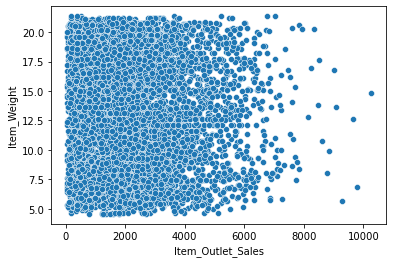

In [8]:
# Checking the ralation between Features and label
sns.scatterplot(x=data['Item_Outlet_Sales'], y=data['Item_Weight'])

C:\Users\HP\new_anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Item_Visibility'>

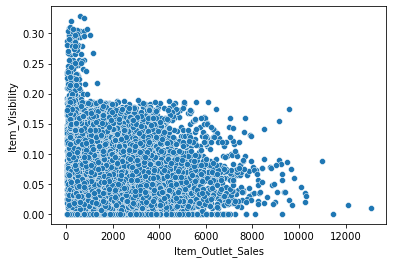

In [9]:
sns.scatterplot(data['Item_Outlet_Sales'],data['Item_Visibility'])

C:\Users\HP\new_anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Item_MRP'>

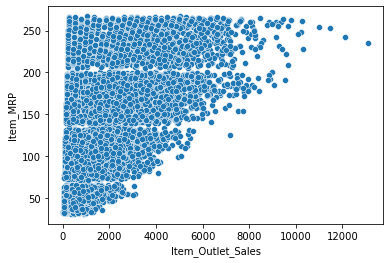

In [10]:
sns.scatterplot(data['Item_Outlet_Sales'],data['Item_MRP'])

C:\Users\HP\new_anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>

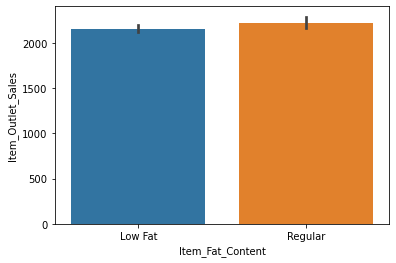

In [11]:
sns.barplot(data['Item_Fat_Content'], data['Item_Outlet_Sales'])

C:\Users\HP\new_anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


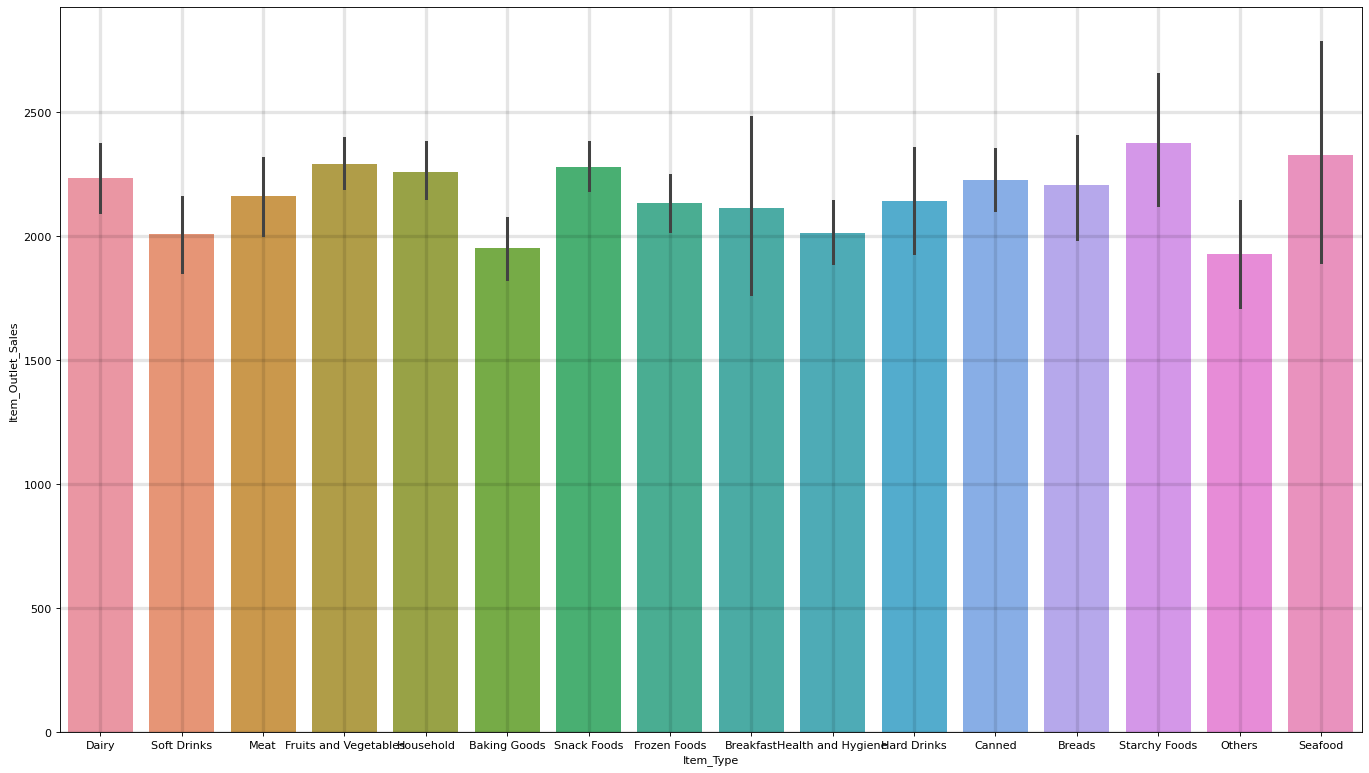

In [12]:
from matplotlib.pyplot import figure
figure(figsize=(21,12), dpi=80)
sns.barplot(data['Item_Type'], data['Item_Outlet_Sales'])
plt.grid(color='black', linewidth=3, axis='both', alpha=0.1)

C:\Users\HP\new_anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

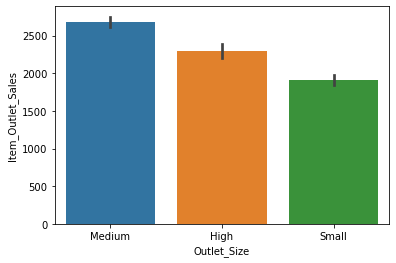

In [13]:
sns.barplot(data['Outlet_Size'], data['Item_Outlet_Sales'])

C:\Users\HP\new_anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outlet_Location_Type', ylabel='Item_Outlet_Sales'>

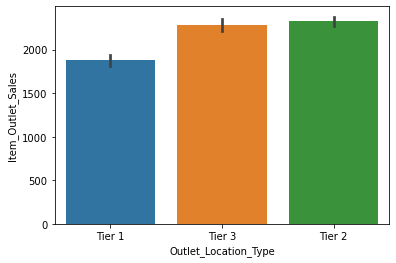

In [14]:
sns.barplot(data['Outlet_Location_Type'], data['Item_Outlet_Sales'])

C:\Users\HP\new_anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>

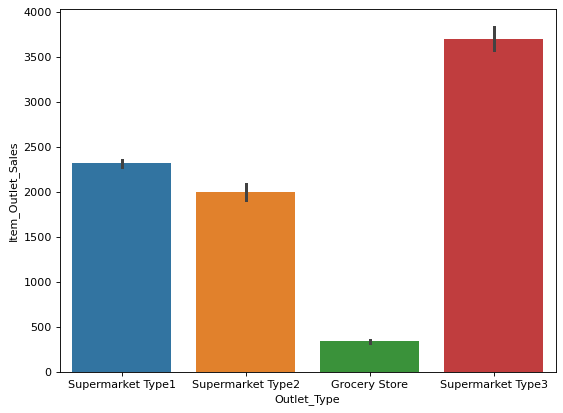

In [15]:
from matplotlib.pyplot import figure
figure(figsize=(8,6), dpi=80)
sns.barplot(data['Outlet_Type'], data['Item_Outlet_Sales'])

C:\Users\HP\new_anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


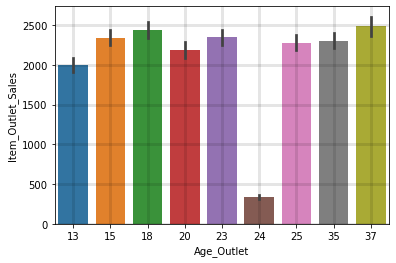

In [16]:
sns.barplot(data['Age_Outlet'], data['Item_Outlet_Sales'])
plt.grid(color='black', linewidth=3, axis='both', alpha=0.1)

In [124]:
encoded_data = categorical_encoding(data)

In [125]:
complete_data = missing_imputer(encoded_data)

In [126]:
outlierfree_data = outlierhandling(complete_data)

In [100]:
scaled_data = scaling(outlierfree_data)

In [71]:
scaled_data.columns

Index(['Item_Weight', 'Outlet_Size', 'Item_Fat_Content',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Type', 'Item_Visibility',
       'Item_MRP', 'Age_Outlet', 'Item_Outlet_Sales'],
      dtype='object')

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Item_Weight'>

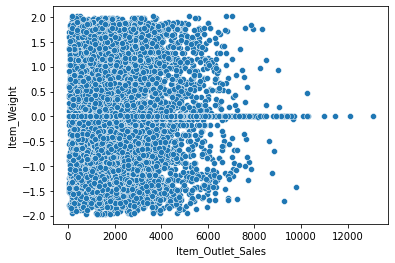

In [22]:
sns.scatterplot(x=scaled_data['Item_Outlet_Sales'], y=scaled_data['Item_Weight'])

C:\Users\HP\new_anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

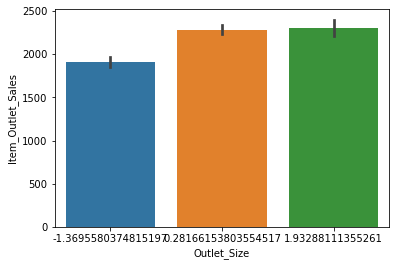

In [23]:
sns.barplot(scaled_data['Outlet_Size'], scaled_data['Item_Outlet_Sales'])

C:\Users\HP\new_anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

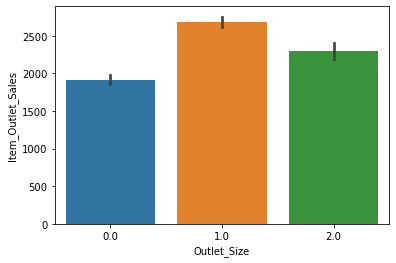

In [24]:
sns.barplot(encoded_data['Outlet_Size'], encoded_data['Item_Outlet_Sales'])

C:\Users\HP\new_anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

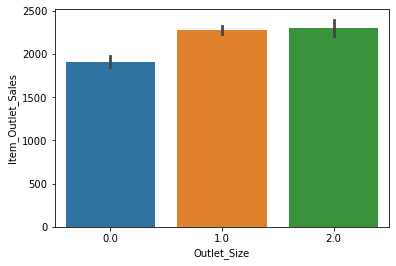

In [25]:
sns.barplot(complete_data['Outlet_Size'], complete_data['Item_Outlet_Sales'])

In [26]:
complete_data['Outlet_Size'].value_counts()

1.0    5203
0.0    2388
2.0     932
Name: Outlet_Size, dtype: int64

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [29]:
X = scaled_data.drop(columns=['Item_Fat_Content'])
y = scaled_data['Item_Fat_Content']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
model = LinearRegression()

In [31]:
model.fit(X_train, y_train)

LinearRegression()

In [32]:
y_pred = model.predict(X_test)

In [33]:
r2_score_acc = r2_score(y_test,y_pred)

In [34]:
r2_score_acc

0.00472055355599299

In [35]:
X_data = complete_data.drop(columns=['Item_Fat_Content'])
y_data = complete_data['Item_Fat_Content']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

data_model = LinearRegression()

In [36]:
data_model.fit(X_train,y_train)

LinearRegression()

In [37]:
y_pred = model.predict(X_test)
mean_squared_error_acc = mean_squared_error(y_test,y_pred, squared=False)

In [38]:
mean_squared_error_acc

3.1191005306221173

In [104]:
# XgBoost Regressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X = outlierfree_data.drop(columns=['Item_Fat_Content'])
y = outlierfree_data['Item_Fat_Content']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbm = XGBRegressor(objective='reg:squarederror')

gbm.fit(X_train,y_train)




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [105]:
predictions_xgr = gbm.predict(X_test)

In [106]:
rmse_xgr = np.sqrt(mean_squared_error(y_test, predictions_xgr))

In [107]:
rmse_xgr

0.2861504579852172

In [108]:
gbm.score(X_train,y_train)

0.8586247197943572

In [109]:
gbm.score(X_test, y_test)

0.6384528140551041

In [120]:
# random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = outlierfree_data.drop(columns=['Item_Fat_Content'])
y = outlierfree_data['Item_Fat_Content']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfr = RandomForestRegressor()


rfr.fit(X_train, y_train)

RandomForestRegressor()

In [121]:
rfr.score(X_train, y_train)

0.9480289727981178

In [122]:
rfr.score(X_test, y_test)

0.6454809130733443

In [111]:
predictions = rfr.predict(X_test)

In [112]:
# accuracy
rmse_rfr = np.sqrt(mean_squared_error(y_test, predictions))

In [113]:
rmse_rfr

0.2653581655267654

In [54]:
scaled_data.columns

Index(['Item_Weight', 'Outlet_Size', 'Item_Fat_Content',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Type', 'Item_Visibility',
       'Item_MRP', 'Age_Outlet', 'Item_Outlet_Sales'],
      dtype='object')

In [127]:
## After Feature Selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

outlierfree_data.drop(columns=['Outlet_Location_Type', 'Item_Visibility', 'Age_Outlet'], inplace=True)
X = outlierfree_data.drop(columns=['Item_Fat_Content'])
y = outlierfree_data['Item_Fat_Content']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfr = RandomForestRegressor()


rfr.fit(X_train, y_train)

RandomForestRegressor()

In [129]:
rfr.score(X_train, y_train)

0.9492251018774346

In [130]:
rfr.score(X_test, y_test)

0.6502263900989407

In [115]:
predictions2 = rfr.predict(X_test)

In [116]:
# accuracy
rmse_rfr2 = np.sqrt(mean_squared_error(y_test, predictions2))

In [117]:
rmse_rfr2

0.2839344049852199

In [118]:
r2 = r2_score(y_test, predictions2)

In [119]:
r2

0.6440310354562908

In [131]:
## Knn Algorithm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

X = outlierfree_data.drop(columns=['Item_Fat_Content'])
y = outlierfree_data['Item_Fat_Content']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = KNeighborsRegressor(n_neighbors=5)
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [132]:
regressor.score(X_test, y_test)

-0.1408205670333278

In [135]:
regressor.score(X_train, y_train)

0.22882008643645457

In [133]:
predictions_knn = rfr.predict(X_test)

In [136]:
rmse_knn = np.sqrt(mean_squared_error(y_test, predictions_knn))

In [138]:
rmse_knn

0.2814527342951721